In [1]:
import sys
# install all libraries, uncomment to do so

#!conda install --yes --prefix {sys.prefix} pandas
#!conda install --yes --prefix {sys.prefix} pip
#!{sys.executable} -m pip install audiolazy
#!conda install --yes --prefix {sys.prefix} matplotlib
#!conda install --yes --prefix {sys.prefix} scipy
#!{sys.executable} -m pip install midiutil
# !{sys.executable} -m pip install pretty_midi
# !{sys.executable} -m pip install mido
# !{sys.executable} -m pip install midi2audio
#!{sys.executable} -m pip install py_midicsv
# !{sys.executable} -m pip install pydub

In [2]:
import pandas as pd

# loads data from csv file
# assumes that the csv have one column named intensity

filename = 'heart2' #name of csv data file
df = pd.read_csv(filename + '.csv')  #load data as a pandas dataframe
df['time'] = df.index
df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce')
# Drop NaN values from that column
df.dropna(subset=['intensity'], inplace=True)

print("Number values before trim:" + str(len(df)))

Number values before trim:5000


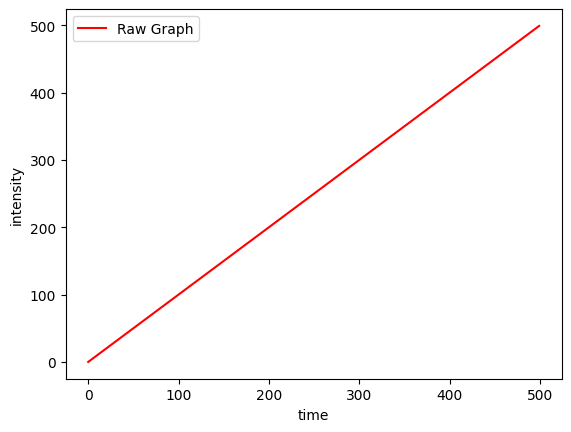

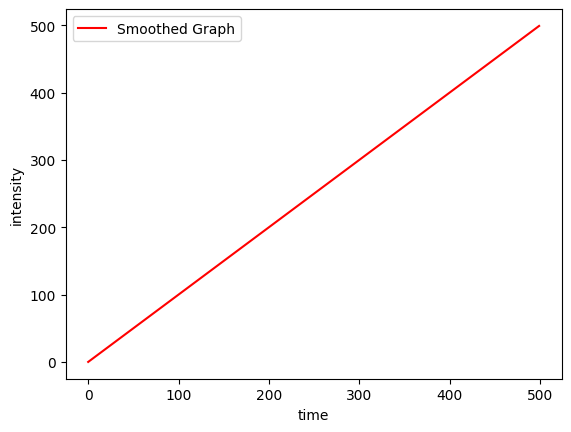

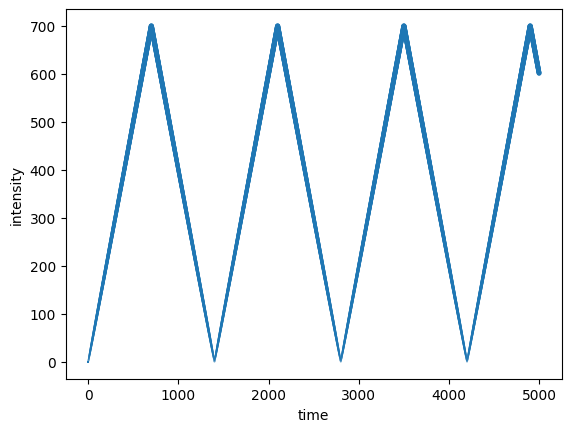

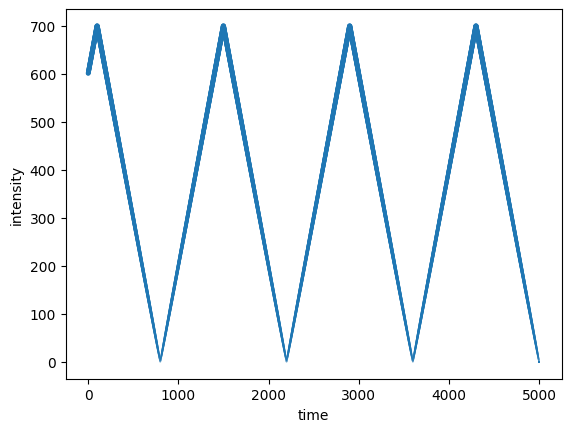

In [3]:
import numpy as np
import matplotlib.pylab as plt 
from scipy.signal import savgol_filter


time = df['time'].values  
intensity = df['intensity'].values 

sample_time = np.array(time[:500])
sample_intensity = np.array(intensity[:500])

# plot the raw graph with a line (first 500 datapoits)
plt.plot(sample_time, sample_intensity, label='Raw Graph', color='red')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()  
plt.show()


window_length = 7  # Adjust this value to your needs, must be odd
poly_order = 4  # Polynomial order. You can play around with this value
smoothed_intensity = savgol_filter(sample_intensity, window_length, poly_order)

# plot the graph after applying Savitzky-Golay filter (first 500 datapoits)
plt.plot(sample_time, smoothed_intensity, label='Smoothed Graph', color='red')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
plt.show()

# apply filter for all datapoints
intensity = savgol_filter(intensity, window_length, poly_order)

plt.scatter(time, intensity, s=intensity * 0.01)
plt.xlabel('time')
plt.ylabel('intensity')
plt.show()

times_millis = max(time) - time 

plt.scatter(times_millis, intensity, s=intensity*0.01)
plt.xlabel('time')
plt.ylabel('intensity')
plt.show()

In [4]:
# defies a function to map from a datarange to another datarange
def map_value(value, min_value, max_value, min_result, max_result):
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

In [5]:
millis_per_beat = 930  #number of datapoints for each beat of music 

t_data = times_millis/millis_per_beat #rescale time from datapoints to beats

duration_beats = max(t_data)  #duration in beats (actually, onset of last note)
print('Duration:', duration_beats, 'beats')

Duration: 5.375268817204301 beats


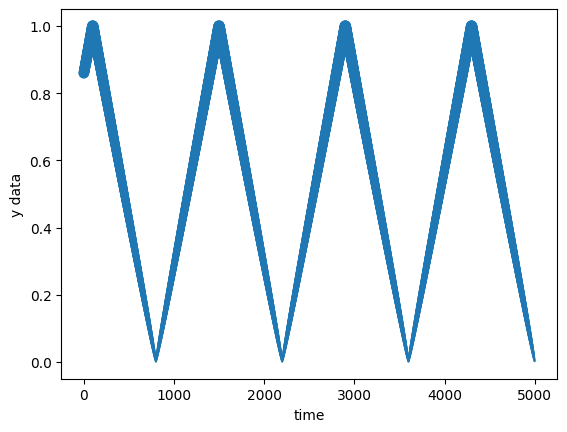

In [6]:
y_data = map_value(intensity, min(intensity), max(intensity), 0, 1) 
y_scale = 1 #lower than 1 to spread out more evenly
y_data = y_data**y_scale

plt.scatter(times_millis, y_data, s=50*y_data)
plt.xlabel('time')
plt.ylabel('y data')
plt.show()

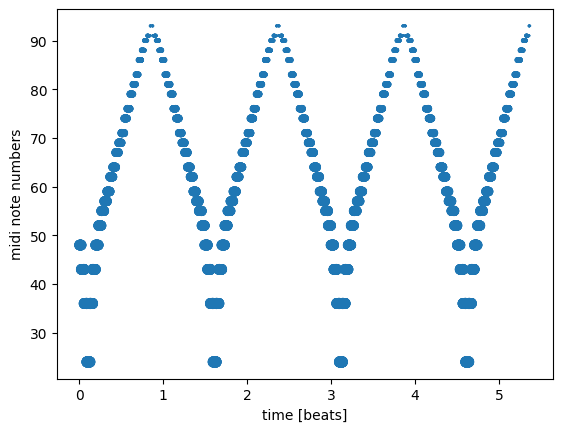

In [7]:
from audiolazy import str2midi, midi2str


note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names] 
n_notes = len(note_midis)

midi_data = []
for i in range(len(y_data)):
    note_index = round(map_value(y_data[i], 0, 1, n_notes-1, 0)) 
    midi_data.append(note_midis[note_index])
    
plt.scatter(t_data, midi_data, s=50*y_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

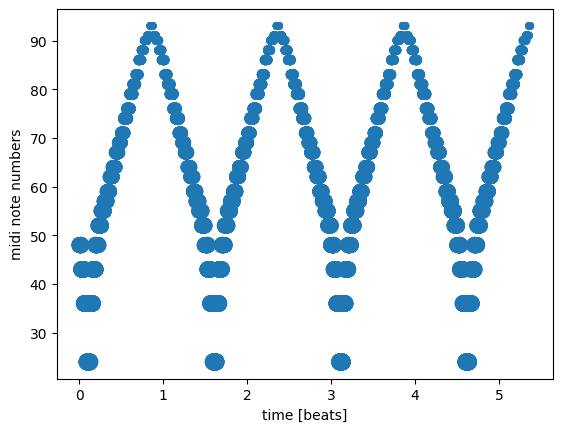

In [8]:
vel_min,vel_max = 20,127   #minimum and maximum note velocity
vel_data = []
for i in range(len(y_data)):
    note_velocity = round(map_value(y_data[i],0,1,vel_min, vel_max)) 
    vel_data.append(note_velocity)
    
plt.scatter(t_data, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

In [9]:
from midiutil import MIDIFile 

# Determine the threshold for the top 10% of velocities
# The purpose is to have the violin for 90% and drum for 10%
sorted_velocity_data = sorted(vel_data)
threshold_index = int(0.9 * len(sorted_velocity_data))
threshold_velocity = sorted_velocity_data[threshold_index]
print("Threshold velocity:", threshold_velocity)

# Create MIDI file
bpm = 60  
duration_sec = duration_beats*60/bpm
print('Duration:', duration_sec, 'seconds')

# Create MIDI files for violin and drum
violin_midi = MIDIFile(1)
drum_midi = MIDIFile(1)

# Add tempo for both MIDI files
violin_midi.addTempo(track=0, time=0, tempo=bpm)
drum_midi.addTempo(track=0, time=0, tempo=bpm)

# Add notes based on the threshold condition
for i in range(len(t_data)):
    if vel_data[i] > threshold_velocity:
        # Add note to the drum MIDI
        # print("drum: " + str(t_data[i]) + ".." +  str(midi_data[i]) + ".." + str(vel_data[i]))
        drum_midi.addNote(track=0, channel=0, time=t_data[i], pitch=midi_data[i], volume=vel_data[i], duration=2)
    else:
        # Add note to the violin MIDI
        # print("violin: " + str(t_data[i]) + ".." +  str(midi_data[i]) + ".." + str(vel_data[i]))
        violin_midi.addNote(track=0, channel=0, time=t_data[i], pitch=midi_data[i], volume=vel_data[i], duration=2)

# Save the violin MIDI file
with open(filename + '_violin.mid', "wb") as f:
    violin_midi.writeFile(f)

# Save the drum MIDI file
with open(filename + '_drum.mid', "wb") as f:
    drum_midi.writeFile(f)

Threshold velocity: 118
Duration: 5.375268817204301 seconds


In [10]:
from midi2audio import FluidSynth


def transform_to_wav(input_midi: str, output_wav: str, sf2_path: str):
    fs = FluidSynth(sf2_path)
    fs.midi_to_audio(input_midi, output_wav)
    print(f'Audio saved to {output_wav}')
    
# Creates to wav files one for violin other for wav
transform_to_wav(filename + '_violin.mid', filename + '_violin.wav', "./soundfont/" + "Levi_s_Violin.sf2")
transform_to_wav(filename + '_drum.mid', filename + '_drum.wav', "./soundfont/" + "Bejeweled_3_Percussions__SF2_.sf2")

fluidsynth: warning: No preset found on channel 9 [bank=128 prog=0]


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'heart2_violin.wav'..
Audio saved to heart2_violin.wav
FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'heart2_drum.wav'..
Audio saved to heart2_drum.wav


fluidsynth: warning: No preset found on channel 9 [bank=128 prog=0]


In [11]:
from pydub import AudioSegment

# Load the two audio files
file1 = AudioSegment.from_wav(filename + '_violin.wav')
file2 = AudioSegment.from_wav(filename + '_drum.wav')

# Overlay the two files
combined_audio = file1.overlay(file2)

# Export the combined audio to a new file
combined_audio.export("combined_output.wav", format="wav")
print("Finished")

Finished
